In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cvxpy as cvx
import pandas as pd
from time import time
%matplotlib inline

from solardatatools.dataio import load_cassandra_data
from solardatatools import DataHandler, PolarTransform
from solardatatools.algorithms import ShadeAnalysis, SoilingAnalysis
from solardatatools.algorithms.shade import make_class_parameters
from solardatatools.utilities import progress
import sys
from os.path import expanduser
home = expanduser("~")

In [54]:
# SAVE = False

SAVE = True

if SAVE:
    import matplotlib
#     sns.set_context('notebook')
    matplotlib.rcParams['axes.unicode_minus'] = False
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [4]:
fp = 's3://pv.insight.sunpower.preprocessed/'
fn = 'system_counts_per_site.csv'
summary_file = pd.read_csv(fp + fn)
fp = 's3://pv.insight.sunpower.preprocessed/'
fn = 'deviceMetaData_LatLon_v2.csv'
loc_data = pd.read_csv(fp + fn, index_col=[0])

In [5]:
siteid = "TADBC1078041" # winter shade
# siteid = "TADBC1076464" # "clean 01"
# siteid = "TAEHC1041562" # "clean 02"
# siteid = 'TAAI01129193' # good capacity change with shade
# siteid = 'TADAC1023097' # use AC 02
# siteid = 'TAEJC1015791' # pole shade to the west
# siteid = '0022F200F291'
# siteid = "TAEJC1014576" # extreme shade
# siteid = 'TABA01148077'
# siteid = "ZT161685000441C0141"
df = load_cassandra_data(siteid)

Query of 193051 rows complete in 3.80 seconds


In [6]:
dh = DataHandler(df, convert_to_ts=True)
dh.keys

[(('TADBC1078041', '657452-3G79-5013_SPR-4200p-TL-1'), 'ac_power_01')]

In [7]:
print(loc_data.loc[siteid]['lat'], loc_data.loc[siteid]['lon'])

33.71824 -117.90722


In [8]:
dh.run_pipeline('ac_power_01', solver='MOSEK', fix_shifts=False)#, end_day_ix=1600)
dh.report()
dh.plot_heatmap(matrix='filled');

total time: 7.78 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.14s
Cleaning                   0.18s
Filtering/Summarizing      4.46s
    Data quality           0.27s
    Clear day detect       0.21s
    Clipping detect        2.99s
    Capacity change detect 1.00s

Length:                3.57 years
Capacity estimate:     3.23 kW
Data sampling:         5 minute
Data quality score:    92.9%
Data clearness score:  45.2%
Inverter clipping:     False
Time shifts corrected: None
Time zone correction:  None


In [9]:
fig = dh.plot_heatmap(matrix='filled', figsize=(5, 3))
plt.title(None)
plt.tight_layout()
if SAVE:
    fig.savefig('pv-data.pgf')

In [16]:
soiling = SoilingAnalysis(dh)
soiling.run()

In [ ]:
df = pandas.load_csv('path/to/data.csv')
dh = DataHandler(df)
soiling = SoilingAnalysis(dh)
soiling.run()
shade = ShadeAnalysis(dh, matrix=soiling.corr_filled_data_matrix)
shade.run()

In [20]:
shade = ShadeAnalysis(dh, matrix=soiling.corr_filled_data_matrix)
params = make_class_parameters(az_min=130, az_max=230, tl_max=30, rank=20)
shade.run(**params)
shade.analyze_yearly_energy()
np.sum(shade.year_analysis_df['shade loss'])

921.7753768703222

In [21]:
shade.year_analysis_df

shade loss  clear sky  SD model  empirical
1      4.705104  12.919222  8.214118   9.181329
2      4.709542  12.983303  8.273762        NaN
3      4.714351  13.052753  8.338403        NaN
4      4.719530  13.127552  8.408022   6.924490
5      4.725078  13.207677  8.482599   6.783551
..          ...        ...       ...        ...
361    4.688537  12.679967  7.991430   7.147639
362    4.691098  12.716949  8.025851   8.055797
363    4.694036  12.759378  8.065342   8.434700
364    4.697350  12.807243  8.109893   8.187165
365    4.701040  12.860530  8.159490   9.245820

[365 rows x 4 columns]

In [19]:
fig = shade.plot_yearly_energy_analysis()

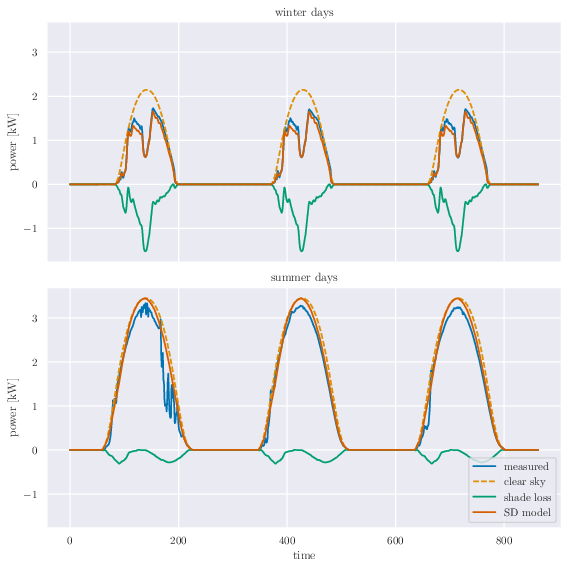

In [161]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))

ix = 603
d = 3
ax[0].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[0].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[0].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[0].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
# ax[0].legend()
ix = 430
d = 3
ax[1].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[1].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[1].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[1].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
ax[1].set_xlabel('time')
ax[0].set_title('winter days')
ax[1].set_title('summer days')
for ix in range(2):
    ax[ix].set_ylabel('power [kW]')
ax[1].legend(loc=4)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example-ts.pgf')



In [162]:
shade = ShadeAnalysis(dh, matrix=soiling.corr_filled_data_matrix)
params = make_class_parameters(az_min=130, az_max=230, tl_max=30, rank=6)
shade.run(**params)
shade.analyze_yearly_energy()
np.sum(shade.daily_shade_loss)

1625.7737239962146

In [ ]:
fig = shade.plot_yearly_energy_analysis()

In [183]:
shade.avg_energy.columns

Index([0], dtype='object')

In [182]:
foo = pd.DataFrame(data={
    'clear': shade.daily_clear_energy
})
foo.join?

In [164]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))

ix = 603
d = 3
ax[0].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[0].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[0].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[0].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
# ax[0].legend()
ix = 430
d = 3
ax[1].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[1].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[1].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[1].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
ax[1].set_xlabel('time')
ax[0].set_title('winter days')
ax[1].set_title('summer days')
for ix in range(2):
    ax[ix].set_ylabel('power [kW]')
ax[1].legend(loc=4)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example-ts.pgf')

In [165]:
shade = ShadeAnalysis(dh, matrix=soiling.corr_filled_data_matrix)
params = make_class_parameters(az_min=80, az_max=280, tl_max=30, rank=20)
shade.run(**params)
shade.analyze_yearly_energy()
np.sum(shade.daily_shade_loss)

926.8527129692751

In [166]:
fig = shade.plot_yearly_energy_analysis()

In [167]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))

ix = 603
d = 3
ax[0].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[0].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[0].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[0].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
# ax[0].legend()
ix = 430
d = 3
ax[1].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[1].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[1].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[1].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
ax[1].set_xlabel('time')
ax[0].set_title('winter days')
ax[1].set_title('summer days')
for ix in range(2):
    ax[ix].set_ylabel('power [kW]')
ax[1].legend(loc=4)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example-ts.pgf')

In [172]:
shade = ShadeAnalysis(dh, matrix=soiling.corr_filled_data_matrix)
params = make_class_parameters(az_min=80, az_max=280, tl_max=30, rank=6)
shade.run(**params)
shade.analyze_yearly_energy()
np.sum(shade.daily_shade_loss)

1509.2380240195944

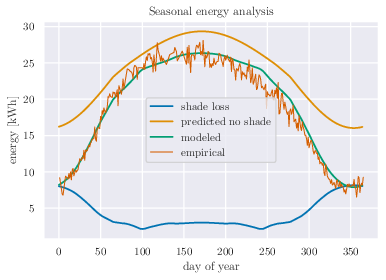

In [173]:
fig = shade.plot_yearly_energy_analysis()

In [174]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))

ix = 603
d = 3
ax[0].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[0].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[0].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[0].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
# ax[0].legend()
ix = 430
d = 3
ax[1].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured')
ax[1].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[1].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss')
ax[1].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model')
ax[1].set_xlabel('time')
ax[0].set_title('winter days')
ax[1].set_title('summer days')
for ix in range(2):
    ax[ix].set_ylabel('power [kW]')
ax[1].legend(loc=4)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example-ts.pgf')

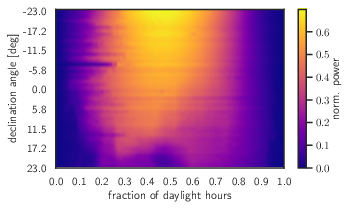

In [139]:
with sns.axes_style('white'):
    fig = shade.plot_transformed_data(yticks=True, figsize=(5, 3))
plt.ylabel('declination angle [deg]')
# plt.xticks(rotation=90)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('transformed-data.pgf')

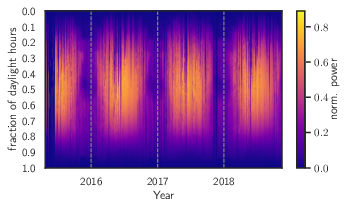

In [140]:
with sns.axes_style('white'):
    plt.figure(figsize=(5, 3))
    ax = plt.gca()
    foo = ax.imshow(shade.data_normalized,
                    cmap="plasma", interpolation='none', aspect='auto')
    plt.colorbar(foo, ax=ax, label='norm. power')
plt.yticks(np.linspace(0, 256, 11), np.round(np.linspace(0, 1, 11), 1))
plt.ylabel('fraction of daylight hours')
mask = np.logical_and(dh.day_index.month == 1, dh.day_index.day == 1)
day_ticks = np.arange(shade.data_normalized.shape[1])[mask]
plt.xticks(day_ticks, dh.day_index[day_ticks].year)
plt.xlabel("Year")
for d in day_ticks:
    plt.axvline(d, ls="--", color="gray", linewidth=1)
# plt.xticks(rotation=90)
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('normalized-data.pgf')

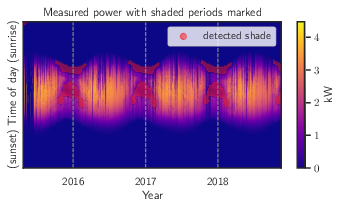

In [141]:
fig = shade.plot_annotated_heatmap(t=0.5, figsize=(5, 3))
plt.tight_layout()
if SAVE:
    fig.savefig('shade-annot.pgf')

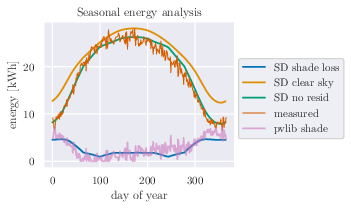

In [142]:
shade_loss = np.loadtxt('shade_loss.txt')
shade_ix = np.loadtxt('shade_ix.txt')
fig = shade.plot_yearly_energy_analysis(figsize=(5, 3))
plt.plot(shade_ix, shade_loss, alpha=0.6, label='pvlib shade loss')
plt.legend(['SD shade loss', 'SD clear sky', 'SD no resid', 'measured', 'pvlib shade'], loc=(1.02,0.2))
plt.tight_layout()
# if SAVE:
#     fig.savefig('shade-energy.pgf')

In [143]:
len(shade_loss)

317

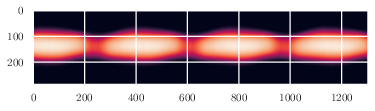

In [144]:
plt.imshow(shade.clear_sky_estimate)

In [135]:
# with sns.axes_style('white'):
#     shade.plot_transformed_data(yticks=False);
# shade.plot_component('clear');
# shade.plot_component('shade');
# shade.plot_component('residual');

In [175]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(nrows=3, figsize=(5, 7.5))
    shade.plot_component('residual', ax=ax[0], cmap='seismic')
    shade.plot_component('clear', ax=ax[1]);
    shade.plot_component('shade', ax=ax[2], cmap='plasma_r');
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example.pgf')

In [27]:
#config
import boto3
import io
import pvlib
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.location import Location
site = 'TADBC1078041'
TIMESHIFT = 8
LEGEND = ['real','model']
PANEL_CELLS = 96
TILT = 19
ALTITUDE = 17
PANELS_PER_STRING = 8
STRINGS = 1
AZIMUTH = 180
PANELS_PER_STRINGv2 = 6
STRINGSv2 = 1
AZIMUTHv2 = 90
# credentials
credentials_loc = '/Users/bennetmeyers/.aws/'
with open(credentials_loc + 'credentials') as f:
    foo = f.read()
    foo = foo.split('\n')
    accessKey = foo[2].split(' = ')[-1]
    keyId = foo[1].split(' = ')[-1]
# load metadeta
s3c = boto3.client(
        's3', 
        aws_access_key_id = keyId,
        aws_secret_access_key = accessKey
    )
obj = s3c.get_object(Bucket='pv.insight.sunpower.preprocessed',
                     Key = 'deviceMetaData_LatLon_v2.csv')
dataframe = pd.read_csv(io.BytesIO(obj['Body'].read()),
                        encoding='utf8')

metadata=dataframe.loc[(dataframe['site']==site)]
lat,lon =metadata['lat'],metadata['lon']
# make pvlib model
loc = Location(float(lat),float(lon),tz='UTC',altitude= ALTITUDE)
clearSky = loc.get_clearsky(dh.data_frame['ac_power_01'].index.shift(TIMESHIFT, freq='h'), 
                            model='simplified_solis')
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['insulated_back_glass_polymer']

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

if PANEL_CELLS == 72:
    spr_label = 'spr_2'
else:
    spr_label = 'spr_3'
panels = [k for k in sandia_modules if spr_label in k.lower()]
panel = panels[0]
inverters = [k for k in cec_inverters if 'spr_4' in k.lower()]
inverter = inverters[0]
system1 = PVSystem(
    surface_tilt=TILT,
    surface_azimuth=AZIMUTH,
    modules_per_string=PANELS_PER_STRING, 
    strings_per_inverter=STRINGS,
    module_parameters=sandia_modules[panel],
    inverter_parameters=cec_inverters[inverter],
    temperature_model_parameters=temperature_model_parameters
)
model1 = ModelChain(system1, loc)
model1.run_model(weather=clearSky)
system2 = PVSystem(
    surface_tilt=TILT,
    surface_azimuth=AZIMUTHv2,
    modules_per_string=PANELS_PER_STRINGv2, 
    strings_per_inverter=STRINGS,
    module_parameters=sandia_modules[panel],
    inverter_parameters=cec_inverters[inverter],
    temperature_model_parameters=temperature_model_parameters
)
model2 = ModelChain(system2, loc)
model2.run_model(weather =clearSky)
model1.ac.index = model1.ac.index.shift(-TIMESHIFT, freq='h')
model2.ac.index = model2.ac.index.shift(-TIMESHIFT, freq='h')
modelac = model1.ac+model2.ac
# run SDT
modelDF = pd.DataFrame(modelac)/1000
modelDF.columns = ['ac']
modelDH = DataHandler(modelDF)
modelDH.run_pipeline(power_col='ac', correct_tz=False, fix_shifts=False)

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/pvlib/modelchain.py:499: pvlibDeprecationWarning: ModelChain.ac is deprecated and will be removed in v0.10. Use ModelChain.results.ac instead
  warnings.warn(msg, pvlibDeprecationWarning)


total time: 10.52 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.25s
Cleaning                   0.17s
Filtering/Summarizing      7.09s
    Data quality           0.32s
    Clear day detect       0.23s
    Clipping detect        5.42s
    Capacity change detect 1.12s



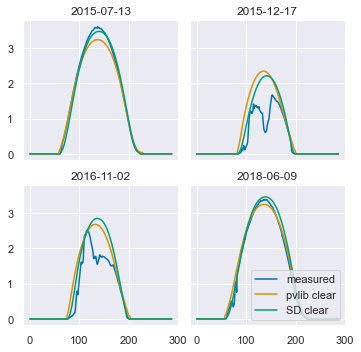

In [46]:
jxs = [10, 90, 235, 500]
ixs = [np.arange(dh.num_days)[dh.daily_flags.clear][jx] for jx in jxs]
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(5,5))
ax = ax.ravel()
for count, ix in enumerate(ixs):
    ax[count].plot(dh.filled_data_matrix[:, ix], label='measured')
    ax[count].plot(modelDH.filled_data_matrix[:, ix], label='pvlib clear')
    ax[count].plot(shade.clear_sky_estimate[:, ix], label='SD clear')
    ax[count].set_title(str(dh.day_index[ix]).split(' ')[0])
plt.tight_layout()
ax[-1].legend(loc=4)

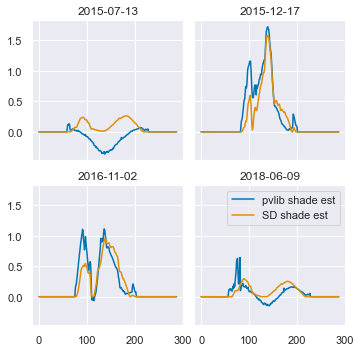

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(5,5))
ax = ax.ravel()
for count, ix in enumerate(ixs):
    ax[count].plot(modelDH.filled_data_matrix[:, ix] - dh.filled_data_matrix[:, ix]
                   , label='pvlib shade est')
    ax[count].plot(shade.shade_estimate[:, ix], label='SD shade est')
    ax[count].set_title(str(dh.day_index[ix]).split(' ')[0])
plt.tight_layout()
ax[-1].legend(loc=0)

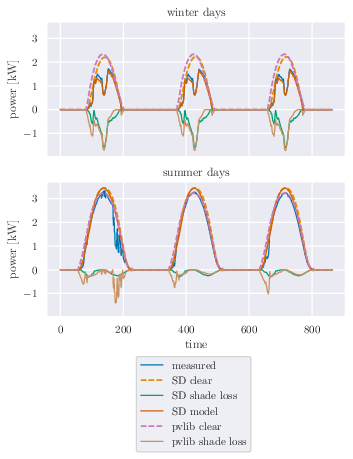

In [140]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(5, 7))

ix = 603
d = 3
ax[0].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured', linewidth=1)
ax[0].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='clear sky', ls='--')
ax[0].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='shade loss', linewidth=1)
ax[0].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model', linewidth=1)
ax[0].plot(modelDH.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='pvlib clear', ls='--')
ax[0].plot(np.clip(-modelDH.filled_data_matrix[:, ix:ix+d].ravel(order='F') 
                   + dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), -np.inf, 0),
           label='pvlib shade est', linewidth=1)
# ax[0].legend()
ix = 430
d = 3
ax[1].plot(dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='measured', linewidth=1)
ax[1].plot(shade.clear_sky_estimate[:, ix:ix+d].ravel(order='F'), label='SD clear', ls='--')
ax[1].plot(-shade.shade_estimate[:, ix:ix+d].ravel(order='F'), label='SD shade loss', linewidth=1)
ax[1].plot(shade.power_estimate[:, ix:ix+d].ravel(order='F'), label='SD model', linewidth=1)
ax[1].plot(modelDH.filled_data_matrix[:, ix:ix+d].ravel(order='F'), label='pvlib clear', ls='--')
ax[1].plot(np.clip(-modelDH.filled_data_matrix[:, ix:ix+d].ravel(order='F') 
                   + dh.filled_data_matrix[:, ix:ix+d].ravel(order='F'), -np.inf, 0),
           label='pvlib shade loss', linewidth=1)
ax[1].set_xlabel('time')
ax[0].set_title('winter days')
ax[1].set_title('summer days')
for ix in range(2):
    ax[ix].set_ylabel('power [kW]')
ax[1].legend(loc=(.3,-1))
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('decompose-example-ts.pgf')
    

In [102]:
FP2 = '/Users/bennetmeyers/Documents/PVInsight/PVInsight_v2/david_f_work/'
# load results file and summary file from google drive (https://docs.google.com/spreadsheets/d/1hYU9a5UgtjVwhKSrxDzzPJ5Uu4507TSgAxigt9dHbdQ/edit?usp=sharing)
results = pd.read_csv(FP2+'analysis_results_20220530_bm.csv', index_col=0)
labels = pd.read_csv(FP2+'SiteStatsValidatingPVSC22 - Sheet1.csv', usecols=(0, 3, 6, 7), index_col=0, nrows=25)
# join results with labels
results = results.join(labels, on='site')
# clean things up
results.index = np.arange(len(results))
results['config'] = results['config'].str.lstrip('_')
results = results.join(results['config'].str.split('_', expand=True).loc[:, [1, 2]])
cols = list(results.columns)
cols[-5] = 'label'
cols[-2] = 'rank'
cols[-1] = 'sd_class'
results['azimuths'] = np.nanmean(results.loc[:, ['azimuths', 'az2']], axis=1)
results.columns = cols
# there is a huge outlier. consider it a failed run
results.loc[results['rmse'] > 50, ['real_total', 'pv_shade_total', 'sd_shade_total', 'percent_total', 
                                   'percent_shade', 'rmse']] = np.nan 

In [105]:
results

site       config    real_total  pv_shade_total  sd_shade_total  \
0   TADAC1037040  SD_r20_wide   3550.418261      652.371289      665.839817   
1   TADCC1097337  SD_r20_wide   7450.058812     1219.556986     1405.907310   
2   TAEEC1018254  SD_r20_wide   5881.775461     1234.677039      715.751991   
3   TABC01142170  SD_r20_wide   5341.415701     3987.561003     1767.690701   
4   TADBC1076739  SD_r20_wide  14205.560081     3011.711490     2172.328892   
5   TADBC1076792  SD_r20_wide   5490.370320     1076.096602      701.653147   
6   TADBC1077995  SD_r20_wide  17025.557780     6482.450839     3362.107913   
7   TAEJC1014464  SD_r20_wide   3209.202582     1298.409264      844.669024   
8   TAEJC1014576  SD_r20_wide   2277.301487     3273.656557     1252.810012   
9   TADBC1078041  SD_r20_wide   5883.499593     1116.867810      809.867434   
10  TAECC1047947  SD_r20_wide   4487.591851      501.224503      816.183738   
11  TAEJC1014877  SD_r20_wide   4848.528506      634.070898      367.364662   
12  TABE01001626  SD_r20_wide   7874.147948     1760.624498     2695.275423   
13  TABF01017766  SD_r20_wide  11551.945923     1683.040355     1406.807980   
14  TABGC1043841  SD_r20_wide  13752.341356     1470.674550     1229.628347   
15  TADBC1076464  SD_r20_wide   5760.293611      673.418980      463.306310   
16  TACIC1066981  SD_r20_wide   5092.806269      327.058015      292.984549   
17  TADBC1077777  SD_r20_wide   3738.442781      540.765305      250.217325   
18  TAAI01129193  SD_r20_wide  14352.655781     1668.589692     1328.115598   
19  TABF01113033  SD_r20_wide   9593.551355     1135.899640      908.098846   
20  TABGC1044406  SD_r20_wide   8876.891283     1715.088058      912.703826   
21  TABJC1027266  SD_r20_wide   9103.504222     1198.695098     2020.907410   
22  TABJC1067952  SD_r20_wide   7323.683046      588.286380      446.903171   
23  TABLC1013976  SD_r20_wide   9268.626187      963.554402      659.952177   
24  TABA01148163  SD_r20_wide   8818.663258     2128.444884     1717.374991   

    percent_total  percent_shade       rmse label  azimuths    az2 rank  \
0        0.379350       2.064549   0.731302     M     179.0    NaN  r20   
1        2.501327      15.280165   1.738900     M      88.0    NaN  r20   
2       -8.822592     -42.029213   2.638792     M     166.0    NaN  r20   
3      -41.559587     -55.669877   7.586497     H     223.0    NaN  r20   
4       -5.908831     -27.870618   3.313012     H     190.0    NaN  r20   
5       -6.820004     -34.796454   1.594163     M     225.0  270.0  r20   
6      -18.327405     -48.135235  11.947352     H     253.0    NaN  r20   
7      -14.138722     -34.945857   2.003288     H     274.0    NaN  r20   
8      -88.738648     -61.730561   9.177291     H     182.0    NaN  r20   
9       -5.217989     -27.487620   1.831558     M     133.5  181.0  r20   
10       7.018447      62.837957   1.906497     L     270.0    NaN  r20   
11      -5.500767     -42.062526   1.518988     M     177.5  258.0  r20   
12      11.869867      53.086330   3.341756     H      85.0    NaN  r20   
13      -2.391219     -16.412701   1.710071     M     219.0    NaN  r20   
14      -1.752765     -16.390180   1.990999     L     180.0    NaN  r20   
15      -3.647603     -31.200883   2.024250     M     180.0  180.0  r20   
16      -0.669051     -10.418172   0.840025     L     180.0    NaN  r20   
17      -7.771899     -53.729035   1.396721     L     183.0    NaN  r20   
18      -2.372203     -20.404902   2.147694     M     169.0  213.0  r20   
19      -2.374520     -20.054658   1.776001     M     177.0    NaN  r20   
20      -9.039023     -46.783850   2.744428     M     155.0  110.0  r20   
21       9.031822      68.592281   2.479164     L     270.0    NaN  r20   
22      -1.930493     -24.033058   1.154503     L     152.0    NaN  r20   
23      -3.275590     -31.508571   1.391948     M     214.0    NaN  r20   
24      -4.661363     -19.313157   1.978249     M     184.0    NaN  r20   

   sd_

TADBC1078041


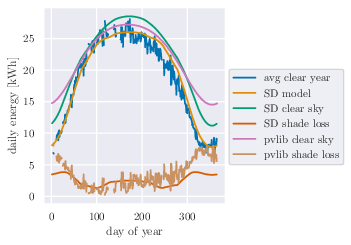

In [107]:
site_id = results.loc[9, 'site']
print(site_id)
fp = site_id + "_" + results.loc[9, 'config'] + '.csv'
file = pd.read_csv(FP2+'bm_output/' + fp, index_col=0)
fp = site_id + "_" + 'pvlib' + '.csv'
file_pvlib = pd.read_csv(FP2+'bm_output/' + fp, index_col=0)
plt.figure(figsize=(5,3.5))
plt.plot(file['empirical'], label='avg clear year')
plt.plot(file['SD model'], label='SD model')
plt.plot(file['clear sky'], label='SD clear sky')
plt.plot(file['shade loss'], label='SD shade loss')
plt.plot(file_pvlib['modelled'], label='pvlib clear sky')
plt.plot(file_pvlib['difference'], label='pvlib shade loss')
plt.legend(loc=(1.02,0.2))
plt.xlabel('day of year')
plt.ylabel('daily energy [kWh]')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('shade-energy.pgf')

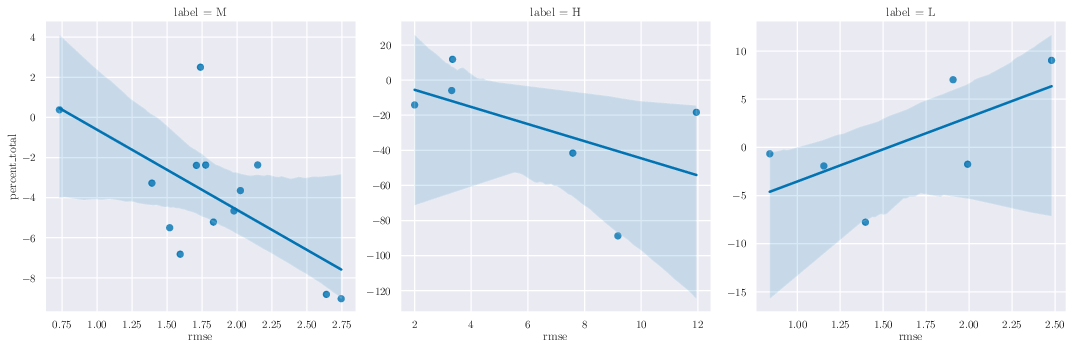

In [108]:
sns.lmplot(data=results, x='rmse', y='percent_total', col='label', facet_kws={
    'sharex': False, 'sharey': False});
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('fleet errors.pgf')

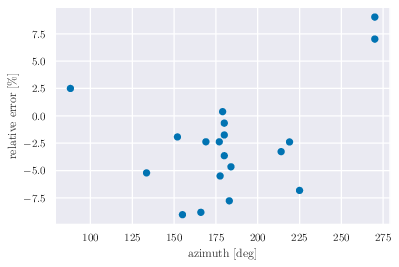

In [125]:
data=results[results['label'] != 'H']
plt.scatter(data['azimuths'], data['percent_total'])
plt.xlabel('azimuth [deg]')
plt.ylabel('relative error [%]')
if SAVE:
    plt.gcf().savefig('fleet-azimuth.pgf');

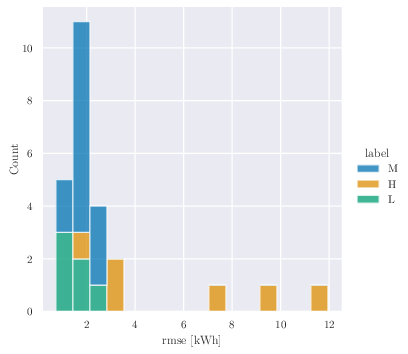

In [124]:
sns.displot(data=results, x='rmse', hue='label', multiple='stack')
plt.xlabel('rmse [kWh]')
# plt.tight_layout()
if SAVE:
    plt.gcf().savefig('fleet-rmse.pgf')

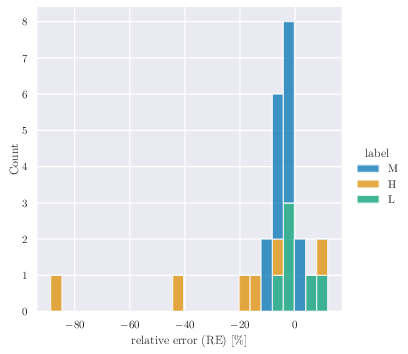

In [112]:
sns.displot(data=results, x='percent_total', hue='label', multiple='stack')
plt.xlabel('relative error (RE) [%]')
if SAVE:
    plt.gcf().savefig('fleet-re.pgf')

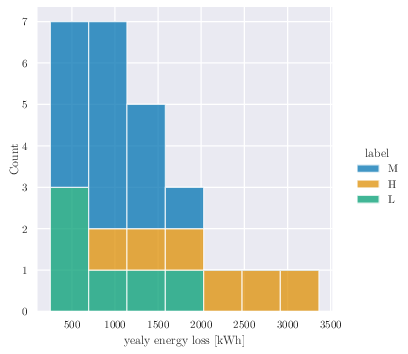

In [120]:
sns.displot(data=results, x='sd_shade_total', hue='label', multiple='stack')
plt.xlabel('yealy energy loss [kWh]')
if SAVE:
    plt.gcf().savefig('fleet-total-losses.pgf')

In [113]:
gb = results.groupby('label')

In [114]:
gb.mean()

real_total  pv_shade_total  sd_shade_total  percent_total  \
label                                                               
H      8322.197597     3302.402275     2015.813661     -26.133888   
L      7249.728254      771.117309      842.804090       0.654344   
M      7794.406027     1223.205895      927.903392      -3.941707   

       percent_shade      rmse    azimuths    az2  
label                                              
H         -29.210969  6.228199  201.166667    NaN  
L           4.476632  1.627985  205.833333    NaN  
M         -24.208448  1.832796  174.384615  202.0

In [116]:
gb.std()

real_total  pv_shade_total  sd_shade_total  percent_total  \
label                                                               
H      6035.424240     1847.189514      928.869512      35.257543   
L      3750.647076      453.590801      685.341845       6.259592   
M      3004.510312      461.388584      410.543844       3.300323   

       percent_shade      rmse   azimuths        az2  
label                                                 
H          42.245133  3.947925  67.014675        NaN  
L          49.749054  0.605376  50.968291        NaN  
M          17.647287  0.518639  36.392051  58.770741

In [134]:
# west facing system that does poorly
west_example = pd.read_csv(FP2 + 'PVSC22_notebooks/' + 'TABJC1027266_example_day.csv', index_col=0)

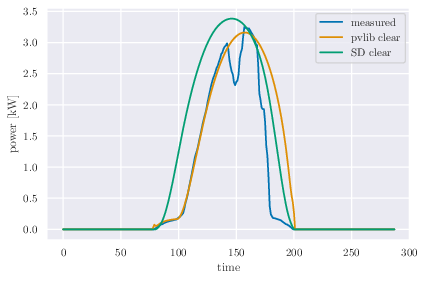

In [135]:
west_example.plot()
plt.xlabel('time')
plt.ylabel('power [kW]')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('west-example.pgf')

In [136]:
# high shade example where SD estimates low
high_shade_example = pd.read_csv(FP2 + 'PVSC22_notebooks/' + 'TADBC1077995_example_day.csv', index_col=0)

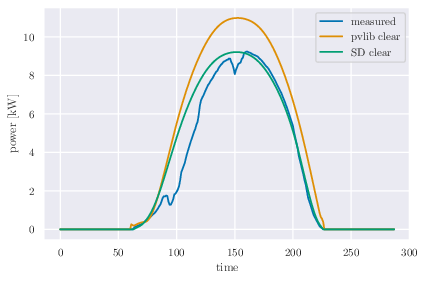

In [138]:
high_shade_example.plot()
plt.xlabel('time')
plt.ylabel('power [kW]')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('high-shade-example.pgf')